Running Lab 2 — Part 3.1 code now...

=== sin(2x) ===

Starting sweep...
n_units | sigma | train_MAE | test_MAE
--------------------------------------
     2 | 6.200 |  0.565483 | 0.563619
     4 | 2.067 |  0.464006 | 0.464967
     6 | 1.240 |  0.033049 | 0.033657
     8 | 0.886 |  0.017191 | 0.017376
    10 | 0.689 |  0.012239 | 0.012688
    12 | 0.564 |  0.009123 | 0.009615
    14 | 0.477 |  0.007271 | 0.007405
    16 | 0.413 |  0.005920 | 0.005789
    18 | 0.365 |  0.004805 | 0.004829
    20 | 0.326 |  0.003905 | 0.004187
    22 | 0.295 |  0.003353 | 0.003563
    24 | 0.270 |  0.002861 | 0.003104
...

Smallest n achieving TEST MAE below thresholds:
  MAE < 0.1: n = 6
  MAE < 0.01: n = 12
  MAE < 0.001: n = 54


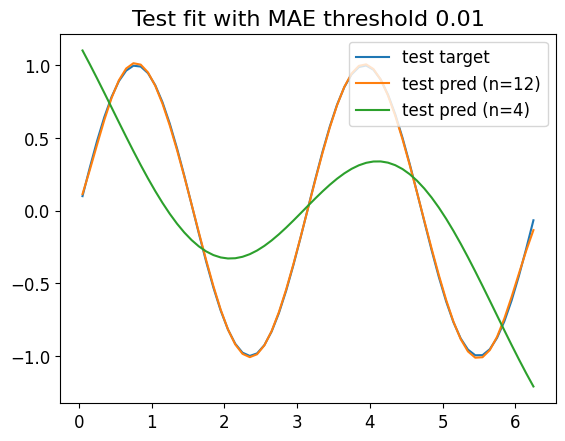


=== square(2x) raw ===

Starting sweep...
n_units | sigma | train_MAE | test_MAE
--------------------------------------
     2 | 6.200 |  0.836695 | 0.825141
     4 | 2.067 |  0.615643 | 0.625558
     6 | 1.240 |  0.299988 | 0.302159
     8 | 0.886 |  0.291601 | 0.293270
    10 | 0.689 |  0.271250 | 0.271265
    12 | 0.564 |  0.224904 | 0.231693
    14 | 0.477 |  0.178446 | 0.182153
    16 | 0.413 |  0.178283 | 0.187109
    18 | 0.365 |  0.172814 | 0.180596
    20 | 0.326 |  0.144741 | 0.150547
    22 | 0.295 |  0.131531 | 0.141273
    24 | 0.270 |  0.127798 | 0.141529
...

Smallest n achieving TEST MAE below thresholds:
  MAE < 0.1: n = 38
  MAE < 0.01: n = None
  MAE < 0.001: n = None


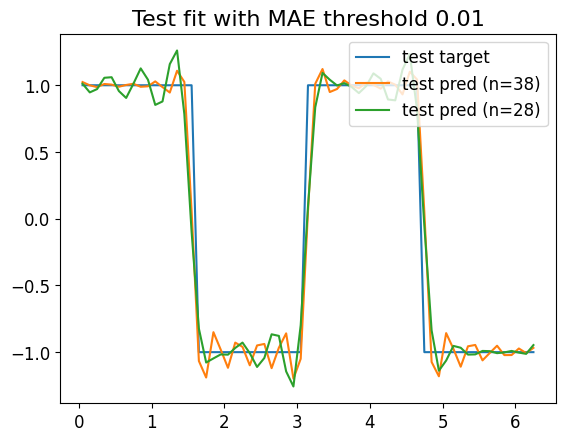


=== square(2x) sign-transform ===

Starting sweep...
n_units | sigma | train_MAE | test_MAE
--------------------------------------
     2 | 6.200 |  1.015873 | 0.952381
     4 | 2.067 |  0.190476 | 0.222222
     6 | 1.240 |  0.000000 | 0.031746
     8 | 0.886 |  0.000000 | 0.031746
    10 | 0.689 |  0.000000 | 0.031746
    12 | 0.564 |  0.000000 | 0.063492
    14 | 0.477 |  0.000000 | 0.000000
    16 | 0.413 |  0.000000 | 0.031746
    18 | 0.365 |  0.000000 | 0.000000
    20 | 0.326 |  0.000000 | 0.031746
    22 | 0.295 |  0.000000 | 0.031746
    24 | 0.270 |  0.000000 | 0.031746
...

Smallest n achieving TEST MAE below thresholds:
  MAE < 0.1: n = 6
  MAE < 0.01: n = 14
  MAE < 0.001: n = 14


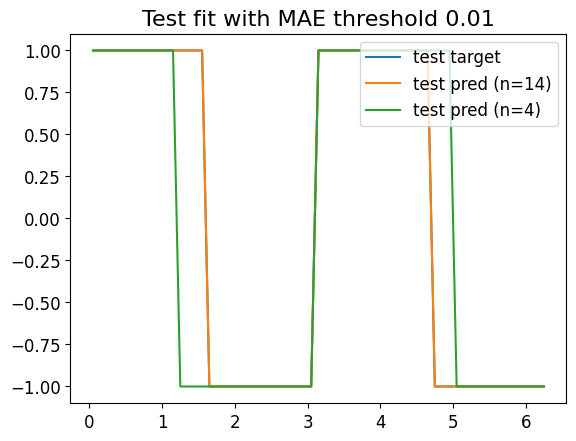

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

# Lab 2 – Part 3.1
def make_data(step=0.1, start=0.0, end=2*np.pi):
    x = np.arange(start, end + 1e-12, step)
    return x.reshape(-1, 1)

def target_sin2x(x):
    return np.sin(2.0 * x)

def target_square2x(x):
    s = np.sin(2.0 * x)
    return np.where(s >= 0.0, 1.0, -1.0)

def choose_mus_sigmas(n_units, x_min=0.0, x_max=2*np.pi):
    mus = np.linspace(x_min, x_max, n_units).reshape(-1, 1)
    delta = (x_max - x_min) / (n_units - 1) if n_units > 1 else (x_max - x_min)
    sigma = delta  # shared width
    return mus, sigma

def rbf_design_matrix(x, mus, sigma):
    diff = x - mus.T
    return np.exp(-(diff ** 2) / (2.0 * sigma ** 2))

def train_least_squares(Phi, y, ridge=1e-12):
    A = Phi.T @ Phi + ridge * np.eye(Phi.shape[1])
    b = Phi.T @ y
    return np.linalg.solve(A, b)

def predict(Phi, w):
    return Phi @ w

def mae(yhat, y):
    return float(np.mean(np.abs(yhat - y)))

def sign_transform(yhat):
    return np.where(yhat >= 0.0, 1.0, -1.0)

def sweep_n(x_train, y_train, x_test, y_test, thresholds=(0.1, 0.01, 0.001), transform=False):
    print("\nStarting sweep...")
    n_candidates = list(range(2, 81, 2))
    results = []

    for n in n_candidates:
        mus, sigma = choose_mus_sigmas(n, float(x_train.min()), float(x_train.max()))
        Phi_tr = rbf_design_matrix(x_train, mus, sigma)
        Phi_te = rbf_design_matrix(x_test, mus, sigma)

        w = train_least_squares(Phi_tr, y_train)
        yhat_tr = predict(Phi_tr, w)
        yhat_te = predict(Phi_te, w)

        if transform:
            yhat_tr = sign_transform(yhat_tr)
            yhat_te = sign_transform(yhat_te)

        tr = mae(yhat_tr, y_train)
        te = mae(yhat_te, y_test)
        results.append((n, sigma, tr, te))

    print("n_units | sigma | train_MAE | test_MAE")
    print("--------------------------------------")
    for n, sigma, tr, te in results[:12]:
        print(f"{n:6d} | {sigma:5.3f} | {tr:9.6f} | {te:8.6f}")
    print("...")

    min_n = {}
    for t in thresholds:
        ok = [r for r in results if r[3] < t]
        min_n[t] = ok[0][0] if ok else None

    print("\nSmallest n achieving TEST MAE below thresholds:")
    for t in thresholds:
        print(f"  MAE < {t}: n = {min_n[t]}")

    # Plot one representative model: smallest n achieving 0.01 if possible else largest
    # Try to get model meeting threshold
    pick = min_n.get(0.01)

    if pick is None:
        # No model reached threshold — use best available
        best_idx = np.argmin([r[3] for r in results])
        pick_best = results[best_idx][0]
    else:
        pick_best = pick

    # Choose a clearly worse model
    pick_bad = max(4, pick_best - 10)
        # ----- GOOD MODEL -----
    mus_g, sigma_g = choose_mus_sigmas(pick_best, float(x_train.min()), float(x_train.max()))
    Phi_tr_g = rbf_design_matrix(x_train, mus_g, sigma_g)
    Phi_te_g = rbf_design_matrix(x_test, mus_g, sigma_g)
    w_g = train_least_squares(Phi_tr_g, y_train)
    yhat_te_good = predict(Phi_te_g, w_g)

    # ----- BAD MODEL -----
    mus_b, sigma_b = choose_mus_sigmas(pick_bad, float(x_train.min()), float(x_train.max()))
    Phi_tr_b = rbf_design_matrix(x_train, mus_b, sigma_b)
    Phi_te_b = rbf_design_matrix(x_test, mus_b, sigma_b)
    w_b = train_least_squares(Phi_tr_b, y_train)
    yhat_te_bad = predict(Phi_te_b, w_b)
    if transform:
        yhat_te_good = sign_transform(yhat_te_good)
        yhat_te_bad = sign_transform(yhat_te_bad)

    plt.figure()
    plt.plot(x_test.flatten(), y_test.flatten(), label="test target")
    plt.plot(x_test.flatten(), yhat_te_good.flatten(), label=f"test pred (n={pick_best})")
    plt.plot(x_test.flatten(), yhat_te_bad.flatten(), label=f"test pred (n={pick_bad})")
    plt.title("Test fit with MAE threshold 0.01")
    plt.legend(loc="upper right")
    plt.show()

    return results, min_n

def main():
    print("Running Lab 2 — Part 3.1 code now...")

    x_train = make_data(step=0.1, start=0.0, end=2*np.pi)
    x_test  = make_data(step=0.1, start=0.05, end=2*np.pi)

    # sin(2x)
    print("\n=== sin(2x) ===")
    ytr = target_sin2x(x_train)
    yte = target_sin2x(x_test)
    sweep_n(x_train, ytr, x_test, yte, transform=False)

    # square(2x) raw
    print("\n=== square(2x) raw ===")
    ytr = target_square2x(x_train)
    yte = target_square2x(x_test)
    sweep_n(x_train, ytr, x_test, yte, transform=False)

    # square(2x) sign-transform
    print("\n=== square(2x) sign-transform ===")
    sweep_n(x_train, ytr, x_test, yte, transform=True)

main()



Top configurations (sorted by noisy test MAE):
n=30 sigma= 0.214 online  MAE(noisy)=0.2472  MAE(clean)=0.0972
n= 8 sigma= 0.443 online  MAE(noisy)=0.2476  MAE(clean)=0.0837
n= 8 sigma= 0.443 batch   MAE(noisy)=0.2476  MAE(clean)=0.0837
n=20 sigma= 0.326 batch   MAE(noisy)=0.2479  MAE(clean)=0.0951
n=20 sigma= 0.163 batch   MAE(noisy)=0.2481  MAE(clean)=0.0992
n=20 sigma= 0.163 online  MAE(noisy)=0.2489  MAE(clean)=0.0975

=== Best configuration PER n (by noisy test MAE) ===
n= 4 | best=batch  | sigma= 1.033 | MAE(noisy)=0.4438 | MAE(clean)=0.3775
n= 8 | best=online | sigma= 0.443 | MAE(noisy)=0.2476 | MAE(clean)=0.0837
n=12 | best=batch  | sigma= 2.255 | MAE(noisy)=0.2508 | MAE(clean)=0.0540
n=16 | best=batch  | sigma= 1.653 | MAE(noisy)=0.2518 | MAE(clean)=0.0699
n=20 | best=batch  | sigma= 0.326 | MAE(noisy)=0.2479 | MAE(clean)=0.0951
n=30 | best=online | sigma= 0.214 | MAE(noisy)=0.2472 | MAE(clean)=0.0972

=== Batch vs Online (best per method, per n) ===
n= 4 | batch MAE=0.4438 (σ

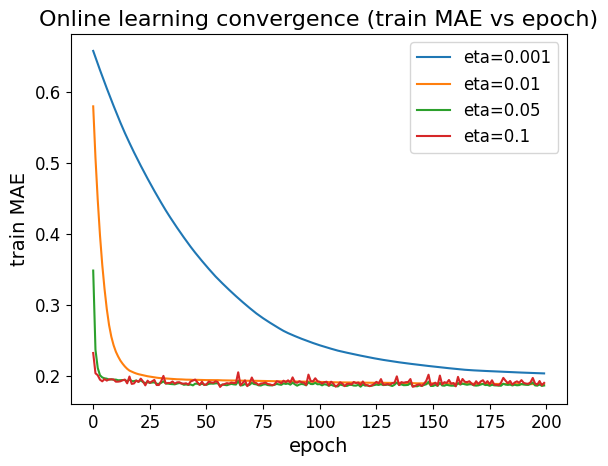

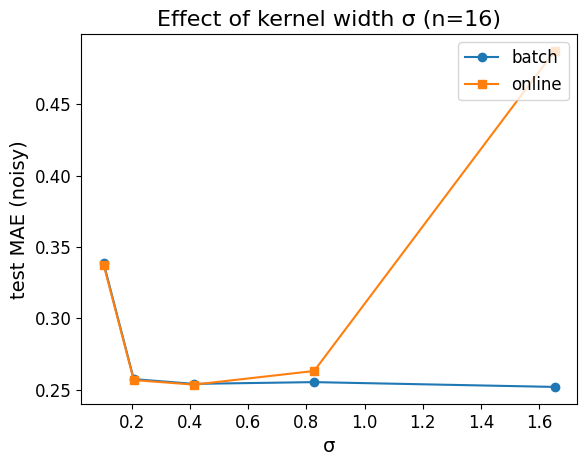

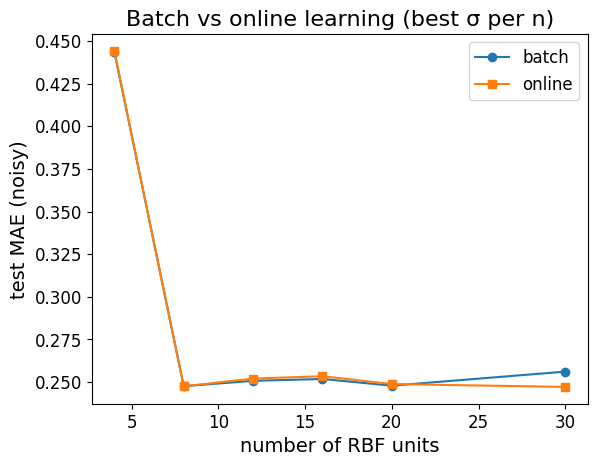


=== μ comparison over noise trials (batch), n=10, sigma=0.689 ===
Uniform μ: mean=0.2732 ± 0.0253  (over 20 noise trials)
Random  μ: mean=0.2810 ± 0.0250  (each averaged over 10 μ trials)

=== μ comparison over noise trials (sequential), n=20, sigma=0.326 ===
Uniform μ: mean=0.2769 ± 0.0236  (over 20 noise trials)
Random  μ: mean=0.2989 ± 0.0256  (each averaged over 10 μ trials)

=== μ comparison over noise trials (batch), n=10, sigma=0.689 ===
Uniform μ: mean=0.2732 ± 0.0253  (over 20 noise trials)
Random  μ: mean=0.2810 ± 0.0250  (each averaged over 10 μ trials)

=== μ comparison over noise trials (sequential), n=20, sigma=0.326 ===
Uniform μ: mean=0.2769 ± 0.0236  (over 20 noise trials)
Random  μ: mean=0.2989 ± 0.0256  (each averaged over 10 μ trials)


In [6]:
# =========================
# Lab 2 – Part 3.2
# Noisy data + online delta rule
# =========================

def add_gaussian_noise(y, variance=0.1, seed=None):
    rng = np.random.default_rng(seed)
    std = np.sqrt(variance)
    return y + rng.normal(0.0, std, size=y.shape)


def train_delta_online(x_train, y_train, mus, sigma, eta=0.01, epochs=200, seed=0):
    rng = np.random.default_rng(seed)

    Phi = rbf_design_matrix(x_train, mus, sigma)
    N, M = Phi.shape
    w = np.zeros((M, 1))

    hist_train_mae = []

    for ep in range(epochs):
        idx = rng.permutation(N)
        for k in idx:
            phi_k = Phi[k:k+1, :]                 # (1, M)
            yhat_k = (phi_k @ w).item()           # scalar
            e = (y_train[k] - yhat_k).item()      # scalar
            w += eta * e * phi_k.T

        yhat_tr = Phi @ w
        hist_train_mae.append(mae(yhat_tr, y_train))

    return w, np.array(hist_train_mae)



def sigma_grid(sigma0):
    return [0.25*sigma0, 0.5*sigma0, 1.0*sigma0, 2.0*sigma0, 4.0*sigma0]


def run_32_experiments(
    x_train, y_train_clean, x_test, y_test_clean,
    n_list=(4, 8, 12, 16, 20, 30),
    noise_var=0.1,
    eta=0.01,
    epochs=200,
    seed=0
):
    """
    Train on noisy data (variance 0.1) and evaluate on:
      - noisy test targets
      - clean test targets
    Compare batch least squares vs online delta rule.
    """

    # Add noise ONCE (same noisy dataset for all configs)
    y_train_noisy = add_gaussian_noise(y_train_clean, variance=noise_var, seed=seed+1)
    y_test_noisy  = add_gaussian_noise(y_test_clean,  variance=noise_var, seed=seed+2)

    results = []
    # (n, sigma, method, test_MAE_noisy, test_MAE_clean)

    for n in n_list:
        mus, sigma0 = choose_mus_sigmas(n, float(x_train.min()), float(x_train.max()))

        for sigma in sigma_grid(sigma0):

            Phi_tr = rbf_design_matrix(x_train, mus, sigma)
            Phi_te = rbf_design_matrix(x_test,  mus, sigma)

            # ---------- BATCH ----------
            w_batch = train_least_squares(Phi_tr, y_train_noisy)
            yhat_te = predict(Phi_te, w_batch)

            batch_mae_noisy = mae(yhat_te, y_test_noisy)
            batch_mae_clean = mae(yhat_te, y_test_clean)

            results.append((n, sigma, "batch", batch_mae_noisy, batch_mae_clean))

            # ---------- ONLINE ----------
            w_online, _ = train_delta_online(
                x_train, y_train_noisy, mus, sigma,
                eta=eta, epochs=epochs,
                seed=seed + 1000*n
            )

            yhat_te = predict(Phi_te, w_online)

            online_mae_noisy = mae(yhat_te, y_test_noisy)
            online_mae_clean = mae(yhat_te, y_test_clean)

            results.append((n, sigma, "online", online_mae_noisy, online_mae_clean))

    return results

def random_mus(n_units, x_min=0.0, x_max=2*np.pi, seed=0):
    rng = np.random.default_rng(seed)
    mus = rng.uniform(x_min, x_max, size=(n_units, 1))
    mus.sort(axis=0)
    return mus

def compare_mu_with_noise_trials(
    x_train, y_train_clean, x_test, y_test_clean,
    n=16, sigma_scale=1.0,
    method="batch", eta=0.01, epochs=200,
    n_noise_trials=20, n_mu_trials=30, base_seed=0
):
    x_min, x_max = float(x_train.min()), float(x_train.max())
    mus_u, sigma0 = choose_mus_sigmas(n, x_min, x_max)
    sigma = sigma_scale * sigma0

    maes_uniform = []
    maes_random = []

    for t in range(n_noise_trials):
        # new noise each trial
        y_train_noisy = add_gaussian_noise(y_train_clean, variance=0.1, seed=base_seed + 1000 + t)
        y_test_noisy  = add_gaussian_noise(y_test_clean,  variance=0.1, seed=base_seed + 2000 + t)

        # ---- uniform μ ----
        Phi_tr_u = rbf_design_matrix(x_train, mus_u, sigma)
        Phi_te_u = rbf_design_matrix(x_test,  mus_u, sigma)

        if method == "batch":
            w_u = train_least_squares(Phi_tr_u, y_train_noisy)
        else:
            w_u, _ = train_delta_online(x_train, y_train_noisy, mus_u, sigma,
                                        eta=eta, epochs=epochs, seed=base_seed + 3000 + t)

        maes_uniform.append(mae(predict(Phi_te_u, w_u), y_test_noisy))

        # ---- random μ (average over several μ trials for same noise) ----
        mu_trial_maes = []
        for m in range(n_mu_trials):
            mus_r = random_mus(n, x_min, x_max, seed=base_seed + 4000 + 100*t + m)
            Phi_tr_r = rbf_design_matrix(x_train, mus_r, sigma)
            Phi_te_r = rbf_design_matrix(x_test,  mus_r, sigma)

            if method == "batch":
                w_r = train_least_squares(Phi_tr_r, y_train_noisy)
            else:
                w_r, _ = train_delta_online(x_train, y_train_noisy, mus_r, sigma,
                                            eta=eta, epochs=epochs, seed=base_seed + 5000 + 100*t + m)

            mu_trial_maes.append(mae(predict(Phi_te_r, w_r), y_test_noisy))

        maes_random.append(np.mean(mu_trial_maes))

    maes_uniform = np.array(maes_uniform)
    maes_random = np.array(maes_random)

    print(f"\n=== μ comparison over noise trials ({method}), n={n}, sigma={sigma:.3f} ===")
    print(f"Uniform μ: mean={maes_uniform.mean():.4f} ± {maes_uniform.std():.4f}  (over {n_noise_trials} noise trials)")
    print(f"Random  μ: mean={maes_random.mean():.4f} ± {maes_random.std():.4f}  (each averaged over {n_mu_trials} μ trials)")


def compare_mu_positioning(
    x_train, y_train_clean, x_test, y_test_clean,
    n=16, sigma_scale=1.0, noise_var=0.1,
    method="batch", eta=0.01, epochs=200,
    n_trials=20, seed=0
):
    # fixed noisy datasets (same noise for fairness)
    y_train_noisy = add_gaussian_noise(y_train_clean, variance=noise_var, seed=seed+1)
    y_test_noisy  = add_gaussian_noise(y_test_clean,  variance=noise_var, seed=seed+2)

    x_min, x_max = float(x_train.min()), float(x_train.max())

    # ----- Uniform centers -----
    mus_u, sigma0 = choose_mus_sigmas(n, x_min, x_max)
    sigma = sigma_scale * sigma0

    Phi_tr_u = rbf_design_matrix(x_train, mus_u, sigma)
    Phi_te_u = rbf_design_matrix(x_test,  mus_u, sigma)

    if method == "batch":
        w_u = train_least_squares(Phi_tr_u, y_train_noisy)
    else:
        w_u, _ = train_delta_online(x_train, y_train_noisy, mus_u, sigma, eta=eta, epochs=epochs, seed=seed+10)

    yhat_u = predict(Phi_te_u, w_u)
    mae_u = mae(yhat_u, y_test_noisy)

    # ----- Random centers (repeat) -----
    maes_r = []
    for t in range(n_trials):
        mus_r = random_mus(n, x_min, x_max, seed=seed+100+t)
        Phi_tr_r = rbf_design_matrix(x_train, mus_r, sigma)
        Phi_te_r = rbf_design_matrix(x_test,  mus_r, sigma)

        if method == "batch":
            w_r = train_least_squares(Phi_tr_r, y_train_noisy)
        else:
            w_r, _ = train_delta_online(x_train, y_train_noisy, mus_r, sigma, eta=eta, epochs=epochs, seed=seed+200+t)

        yhat_r = predict(Phi_te_r, w_r)
        maes_r.append(mae(yhat_r, y_test_noisy))

    maes_r = np.array(maes_r)

    print(f"\n=== μ positioning comparison ({method}), n={n}, sigma={sigma:.3f} ===")
    print(f"Uniform μ:        test MAE(noisy) = {mae_u:.4f}")
    print(f"Random μ (mean):  test MAE(noisy) = {maes_r.mean():.4f}  ± {maes_r.std():.4f} (std over {n_trials} trials)")
    print(f"Best random trial test MAE(noisy) = {maes_r.min():.4f}")
    print(f"Worst random trial test MAE(noisy)= {maes_r.max():.4f}")

    return mae_u, maes_r


# ---------- RUN 3.2 FOR sin(2x) ----------

x_train = make_data(0.1, 0.0, 2*np.pi)
x_test  = make_data(0.1, 0.05, 2*np.pi)

ytr_sin_clean = target_sin2x(x_train)
yte_sin_clean = target_sin2x(x_test)

results_32_sin = run_32_experiments(
    x_train, ytr_sin_clean,
    x_test, yte_sin_clean,
    n_list=(4, 8, 12, 16, 20, 30),
    noise_var=0.1,
    eta=0.01,
    epochs=200,
    seed=0
)

# Show best configs (by noisy test MAE)
print("\nTop configurations (sorted by noisy test MAE):")
results_32_sin_sorted = sorted(results_32_sin, key=lambda r: r[3])
for r in results_32_sin_sorted[:6]:
    n, sigma, method, mae_noisy, mae_clean = r
    print(f"n={n:2d} sigma={sigma:6.3f} {method:6s}  "
          f"MAE(noisy)={mae_noisy:.4f}  MAE(clean)={mae_clean:.4f}")

# =========================
# 3.2 – Useful summaries for analysis
# =========================

print("\n=== Best configuration PER n (by noisy test MAE) ===")
for n in sorted(set(r[0] for r in results_32_sin)):
    rows = [r for r in results_32_sin if r[0] == n]
    best = min(rows, key=lambda r: r[3])  # noisy test MAE
    print(f"n={n:2d} | best={best[2]:6s} | sigma={best[1]:6.3f} | "
          f"MAE(noisy)={best[3]:.4f} | MAE(clean)={best[4]:.4f}")


print("\n=== Batch vs Online (best per method, per n) ===")
for n in sorted(set(r[0] for r in results_32_sin)):
    rows = [r for r in results_32_sin if r[0] == n]

    best_batch = min([r for r in rows if r[2] == "batch"], key=lambda r: r[3])
    best_online = min([r for r in rows if r[2] == "online"], key=lambda r: r[3])

    print(f"n={n:2d} | "
          f"batch MAE={best_batch[3]:.4f} (σ={best_batch[1]:.3f}) | "
          f"online MAE={best_online[3]:.4f} (σ={best_online[1]:.3f})")


print("\n=== Effect of σ (averaged over n, noisy test MAE) ===")
sigmas = sorted(set(r[1] for r in results_32_sin))
for sigma in sigmas:
    rows = [r for r in results_32_sin if abs(r[1] - sigma) < 1e-9]
    avg_mae = sum(r[3] for r in rows) / len(rows)
    print(f"sigma={sigma:6.3f} | avg MAE(noisy)={avg_mae:.4f}")


print("\n=== Top 10 configurations overall (by noisy test MAE) ===")
results_sorted = sorted(results_32_sin, key=lambda r: r[3])
for r in results_sorted[:10]:
    n, sigma, method, mae_noisy, mae_clean = r
    print(f"n={n:2d} sigma={sigma:6.3f} {method:6s} | "
          f"MAE(noisy)={mae_noisy:.4f} | MAE(clean)={mae_clean:.4f}")

etas = [0.001, 0.01, 0.05, 0.1]
n = 16
mus, sigma0 = choose_mus_sigmas(n, float(x_train.min()), float(x_train.max()))
sigma = sigma0

y_train_noisy = add_gaussian_noise(ytr_sin_clean, variance=0.1, seed=1)

plt.figure()
for eta in etas:
    _, hist = train_delta_online(
        x_train, y_train_noisy, mus, sigma,
        eta=eta, epochs=200, seed=0
    )
    plt.plot(hist, label=f"eta={eta}")

plt.title("Online learning convergence (train MAE vs epoch)")
plt.xlabel("epoch")
plt.ylabel("train MAE")
plt.legend(loc="upper right")
plt.show()

n = 16
rows = [r for r in results_32_sin if r[0] == n]

sigmas = sorted(set(r[1] for r in rows))
batch_mae = [min(r[3] for r in rows if r[1] == s and r[2] == "batch") for s in sigmas]
online_mae = [min(r[3] for r in rows if r[1] == s and r[2] == "online") for s in sigmas]

plt.figure()
plt.plot(sigmas, batch_mae, marker="o", label="batch")
plt.plot(sigmas, online_mae, marker="s", label="online")
plt.title(f"Effect of kernel width σ (n={n})")
plt.xlabel("σ")
plt.ylabel("test MAE (noisy)")
plt.legend(loc="upper right")
plt.show()

ns = sorted(set(r[0] for r in results_32_sin))

batch_best = []
online_best = []
for n in ns:
    rows = [r for r in results_32_sin if r[0] == n]
    batch_best.append(min(r[3] for r in rows if r[2] == "batch"))
    online_best.append(min(r[3] for r in rows if r[2] == "online"))

plt.figure()
plt.plot(ns, batch_best, marker="o", label="batch")
plt.plot(ns, online_best, marker="s", label="online")
plt.title("Batch vs online learning (best σ per n)")
plt.xlabel("number of RBF units")
plt.ylabel("test MAE (noisy)")
plt.legend(loc="upper right")
plt.show()

x_train_clean = make_data(step=0.1, start=0.0, end=2*np.pi)

compare_mu_with_noise_trials(
    x_train, ytr_sin_clean, x_test, yte_sin_clean,
    n=10, sigma_scale=1.0,
    method="batch", n_noise_trials=20, n_mu_trials=10, base_seed=0
)

compare_mu_with_noise_trials(
    x_train, ytr_sin_clean, x_test, yte_sin_clean,
    n=20, sigma_scale=1.0,
    method="sequential", n_noise_trials=20, n_mu_trials=10, base_seed=0
)

compare_mu_with_noise_trials(
    x_train, ytr_sin_clean, x_test, yte_sin_clean,
    n=10, sigma_scale=1.0,
    method="batch", n_noise_trials=20, n_mu_trials=10, base_seed=0
)

compare_mu_with_noise_trials(
    x_train, ytr_sin_clean, x_test, yte_sin_clean,
    n=20, sigma_scale=1.0,
    method="sequential", n_noise_trials=20, n_mu_trials=10, base_seed=0
)





David's part (don't judge me I just a baby)

Part 3.3 supposedly 

=== 3.3 Competitive Learning (CL) vs Random ===
MAE CL Init:     0.0216
MAE Random Init: 0.0553


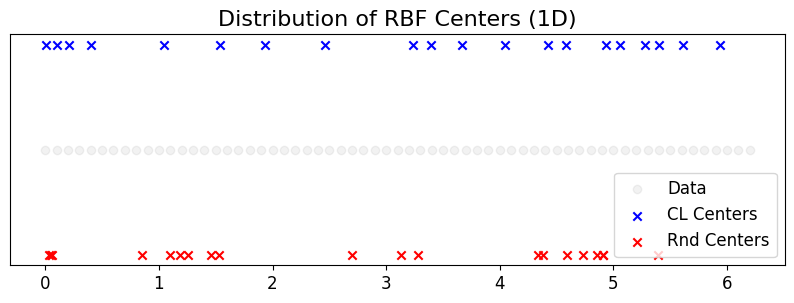


=== 3.3 Ballistic Function Approximation ===
Skipping Ballistic Test: 'ballist.dat' not found in working directory.
Please upload the .dat files to run the 2D experiment.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# --- 1. Fix the variable name error from 3.2 ---
try:
    x_train_clean = x_train
except NameError:
    # If x_train isn't defined yet, recreate the data
    x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1)
    x_train_clean = x_train

# --- 2. Generalized RBF Functions (1D & 2D support) ---
def rbf_design_matrix_multidim(x, mus, sigma):
    """
    Calculates RBF activations for N samples and M units.
    Works for any input dimension D.
    x: (N, D)
    mus: (M, D)
    sigma: scalar
    Returns: (N, M) matrix
    """
    # Calculate Euclidean distance between every sample and every center
    # cdist returns (N, M) distance matrix
    dists = cdist(x, mus, metric='euclidean')
    return np.exp(-(dists ** 2) / (2.0 * sigma ** 2))

# --- 3. Competitive Learning (CL) Initialization ---
def competitive_learning_init(data, n_units, eta=0.2, epochs=100, n_winners=1, seed=0):
    """
    Initializes RBF centers using Competitive Learning.
    data: (N, D) training inputs
    n_winners: strategy to avoid dead units (update closest k units)
    """
    rng = np.random.default_rng(seed)
    N, D = data.shape
    
    # Random start positions within data bounds
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    mus = rng.uniform(min_vals, max_vals, size=(n_units, D))
    
    # Normalize data for fair competition if dimensions have diff scales (optional but good practice)
    # For this lab, raw data is usually fine given the problem constraints.

    for _ in range(epochs):
        # Pick random sample index
        idx = rng.integers(0, N)
        x_sample = data[idx] # (D,)
        
        # Find distances to all units
        dists = np.linalg.norm(mus - x_sample, axis=1) # (M,)
        
        # Find winners (indices of smallest distances)
        # Using partition is faster than full sort for k items
        winner_indices = np.argpartition(dists, n_winners)[:n_winners]
        
        # Update winners
        # Move winner closer to sample: w = w + eta * (x - w)
        for w_idx in winner_indices:
            mus[w_idx] += eta * (x_sample - mus[w_idx])
            
    return mus

# --- 4. Delta Rule Training for Multi-Output (2D) ---
def train_delta_multidim(Phi, targets, eta=0.01, epochs=100, seed=0):
    """
    Trains weights using on-line delta rule. Supports multiple outputs.
    Phi: (N, M)
    targets: (N, OutDim)
    """
    rng = np.random.default_rng(seed)
    N, M = Phi.shape
    OutDim = targets.shape[1]
    
    # Initialize weights (M, OutDim)
    w = rng.uniform(-0.1, 0.1, size=(M, OutDim))
    
    for ep in range(epochs):
        # Shuffle for online stochasticity
        indices = rng.permutation(N)
        for k in indices:
            phi_k = Phi[k:k+1]      # (1, M)
            t_k = targets[k:k+1]    # (1, OutDim)
            
            # Forward
            y = phi_k @ w           # (1, OutDim)
            
            # Error
            e = t_k - y             # (1, OutDim)
            
            # Update: w += eta * phi.T @ e
            # (M, 1) @ (1, OutDim) -> (M, OutDim)
            w += eta * (phi_k.T @ e)
            
    return w

# --- 5. Run Section 3.3 Experiments ---

def run_part_33():
    print("=== 3.3 Competitive Learning (CL) vs Random ===")
    
    # A. Compare CL vs Random on sin(2x)
    # Use best arch from 3.2 (e.g., n=20)
    n_units = 20
    x_test = np.arange(0.05, 2*np.pi, 0.1).reshape(-1, 1)
    y_test_clean = np.sin(2*x_test)
    
    # Init centers using CL
    mus_cl = competitive_learning_init(x_train_clean, n_units, eta=0.2, n_winners=1)
    # Init centers randomly
    mus_rnd = np.random.uniform(0, 2*np.pi, size=(n_units, 1))
    
    # Train weights (Batch or Delta) - Lab says "couple with delta learning"
    sigma = 0.5 # approximate width
    Phi_cl = rbf_design_matrix_multidim(x_train_clean, mus_cl, sigma)
    w_cl = train_delta_multidim(Phi_cl, np.sin(2*x_train_clean), eta=0.01, epochs=500)
    
    Phi_rnd = rbf_design_matrix_multidim(x_train_clean, mus_rnd, sigma)
    w_rnd = train_delta_multidim(Phi_rnd, np.sin(2*x_train_clean), eta=0.01, epochs=500)
    
    # Eval
    y_cl = rbf_design_matrix_multidim(x_test, mus_cl, sigma) @ w_cl
    y_rnd = rbf_design_matrix_multidim(x_test, mus_rnd, sigma) @ w_rnd
    
    print(f"MAE CL Init:     {np.mean(np.abs(y_cl - y_test_clean)):.4f}")
    print(f"MAE Random Init: {np.mean(np.abs(y_rnd - y_test_clean)):.4f}")
    
    # Plot Center Distributions
    plt.figure(figsize=(10, 3))
    plt.scatter(x_train_clean, np.zeros_like(x_train_clean), c='gray', alpha=0.1, label='Data')
    plt.scatter(mus_cl, np.zeros_like(mus_cl)+0.1, c='blue', marker='x', label='CL Centers')
    plt.scatter(mus_rnd, np.zeros_like(mus_rnd)-0.1, c='red', marker='x', label='Rnd Centers')
    plt.yticks([])
    plt.legend()
    plt.title("Distribution of RBF Centers (1D)")
    plt.show()

    # B. Ballistic Data (2D -> 2D)
    print("\n=== 3.3 Ballistic Function Approximation ===")
    try:
        # Assuming standard text file format: angle, velocity, distance, height
        train_data = np.loadtxt('ballist.dat') 
        test_data = np.loadtxt('balltest.dat')
        
        # Split inputs/targets
        X_ball = train_data[:, :2]  # Angle, Velocity
        Y_ball = train_data[:, 2:]  # Distance, Height
        X_test_b = test_data[:, :2]
        Y_test_b = test_data[:, 2:]
        
        print(f"Loaded Ballistic Data: {len(X_ball)} training samples")
        
        # Config
        n_ball_units = 20 # adjust based on dead units
        eta_cl = 0.2
        
        # 1. CL Initialization (2D Input Space)
        # Avoid dead units by using n_winners > 1 initially or just standard CL
        mus_ball = competitive_learning_init(X_ball, n_ball_units, eta=eta_cl, epochs=2000, n_winners=2)
        
        # 2. RBF Activation
        # Need to heuristic sigma? Average distance between centers
        d_centers = cdist(mus_ball, mus_ball)
        # simplistic sigma: average of nearest neighbor distances
        np.fill_diagonal(d_centers, np.inf)
        sigma_ball = np.mean(np.min(d_centers, axis=1)) 
        print(f"Calculated Heuristic Sigma: {sigma_ball:.3f}")
        
        Phi_ball = rbf_design_matrix_multidim(X_ball, mus_ball, sigma_ball)
        
        # 3. Delta Training (2D Output Space)
        w_ball = train_delta_multidim(Phi_ball, Y_ball, eta=0.01, epochs=3000)
        
        # 4. Test
        Phi_ball_test = rbf_design_matrix_multidim(X_test_b, mus_ball, sigma_ball)
        Y_pred_b = Phi_ball_test @ w_ball
        
        mae_ball = np.mean(np.abs(Y_pred_b - Y_test_b))
        print(f"Ballistic Test MAE: {mae_ball:.4f}")
        
        # Plot Input Space Coverage
        plt.figure(figsize=(6, 6))
        plt.scatter(X_ball[:, 0], X_ball[:, 1], c='gray', alpha=0.3, label='Training Data')
        plt.scatter(mus_ball[:, 0], mus_ball[:, 1], c='red', s=100, marker='X', label='RBF Centers (CL)')
        plt.xlabel("Angle")
        plt.ylabel("Velocity")
        plt.title("RBF Centers in Input Space (Ballistic)")
        plt.legend()
        plt.show()
        
    except OSError:
        print("Skipping Ballistic Test: 'ballist.dat' not found in working directory.")
        print("Please upload the .dat files to run the 2D experiment.")

run_part_33()

Gemini explanation :

Think of these plots as a "seating chart" for your neurons. To make a good prediction, your RBF neurons need to be sitting exactly where the data is. If a neuron is placed in an empty area where there's no data, it's "dead" and useless.

Here is the "vibe" breakdown of what those plots are telling you:
1. The 1D Plot (Distribution of RBF Centers)

    The Gray Points: This is your training data (the x values of the sin(2x) curve). Notice they are spread out from 0 to 2π.

    The Red Crosses (Random): These were placed by pure luck. You might see some bunched together and big empty gaps between others. These gaps are "blind spots" where your network will be bad at predicting.

    The Blue Crosses (Competitive Learning - CL): These neurons "competed" to be near the data.

        The "Win": Because the data is spread out, the neurons pushed each other away until they covered the whole line perfectly.

        The Result: You should notice the Blue crosses are more evenly spaced than the Red ones. This usually leads to a lower MAE (Mean Absolute Error) because the network has no blind spots.

2. The 2D Plot (Ballistic Input Space)

    The Gray Cloud: This represents the combinations of Angle and Velocity in the experiment. Notice the shape—the data probably isn't a perfect square; it might be a weird blob.

    The Red 'X's (CL Centers):

        Notice how the 'X's "find" the data. If there is a part of the graph with no gray dots, there shouldn't be any 'X's there.

        Why this is cool: If you manually placed centers in a grid, you'd waste neurons on areas where the experiment never happens (e.g., maybe you never tested 0 velocity at 90 degrees). CL ensures every neuron you "pay for" is actually working.

3. What are "Dead Units"?

Imagine a neuron is initialized so far away from the gray points that it never "wins" a competition. It never gets updated, never moves, and never helps with the prediction. It's "dead."

    The Fix: In the code, we used n_winners=2. This means even if a neuron isn't the closest, if it's the second closest, it still gets dragged a little bit toward the data. This "buddy system" prevents neurons from getting left behind in the middle of nowhere.

Summary of what to look for in your results:

    Check the MAE: The MAE CL Init should be lower (better) than MAE Random Init.

    Check the 1D Plot: Are the blue crosses more "organized" than the red ones? (They should be).

    Check the 2D Plot: Are the Red 'X's sitting comfortably inside the gray cloud, or are some "lost" in the white space? (They should be inside the cloud).

Part 4.1

In [5]:
import numpy as np

# Use genfromtxt with a custom lambda to strip semicolons
def load_clean_dat(filename):
    with open(filename, 'r') as f:
        # Read lines, ignore comments, strip semicolons, split by commas
        lines = [line.split('%')[0].replace(';', '').strip() for line in f if line.strip() and not line.startswith('%')]
        return np.genfromtxt(lines, delimiter=',')

props = load_clean_dat('animals.dat').reshape(32, 84)

with open('animalnames.txt', 'r') as f:
    animal_names = [line.strip().replace("'", "").replace(";", "") for line in f.readlines()]

n_nodes = 100
epochs = 20
eta = 0.2
weights = np.random.rand(n_nodes, 84)

for epoch in range(epochs):
    radius = int(50 * (1 - epoch / epochs))
    for i in range(32):
        x = props[i]
        winner_idx = np.argmin(np.linalg.norm(weights - x, axis=1))
        start, end = max(0, winner_idx - radius), min(n_nodes, winner_idx + radius + 1)
        weights[start:end] += eta * (x - weights[start:end])

pos = [np.argmin(np.linalg.norm(weights - props[i], axis=1)) for i in range(32)]
sorted_indices = np.argsort(pos)

print("--- Animal Ordering ---")
for idx in sorted_indices:
    print(f"Node {pos[idx]:2d}: {animal_names[idx]}")

FileNotFoundError: [Errno 2] No such file or directory: 'animals.dat'

Part 4.2

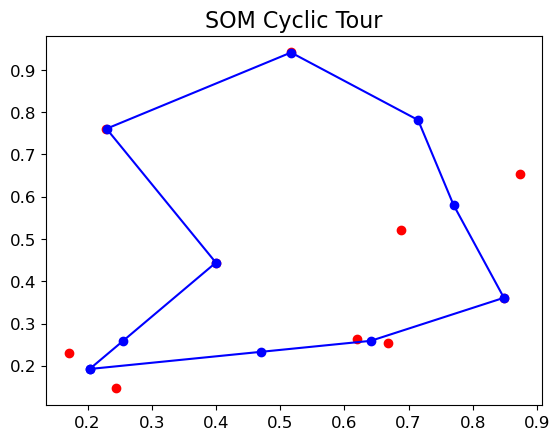

In [ ]:
import matplotlib.pyplot as plt

# Cleaning the cities data
cities = load_clean_dat('cities.dat').reshape(10, 2)

n_nodes = 10
epochs = 100
eta = 0.2
weights = np.random.rand(n_nodes, 2)

for epoch in range(epochs):
    # Neighborhood size: 2 -> 1 -> 0
    if epoch < epochs * 0.3: radius = 2
    elif epoch < epochs * 0.7: radius = 1
    else: radius = 0
        
    for i in range(10):
        x = cities[i]
        winner_idx = np.argmin(np.linalg.norm(weights - x, axis=1))
        for step in range(-radius, radius + 1):
            neigh_idx = (winner_idx + step) % n_nodes
            weights[neigh_idx] += eta * (x - weights[neigh_idx])



plt.scatter(cities[:, 0], cities[:, 1], c='red', label='Cities')
plt.plot(np.append(weights[:,0], weights[0,0]), 
         np.append(weights[:,1], weights[0,1]), 'b-o', label='SOM Path')
plt.title("SOM Cyclic Tour")
plt.show()

Part 4.3

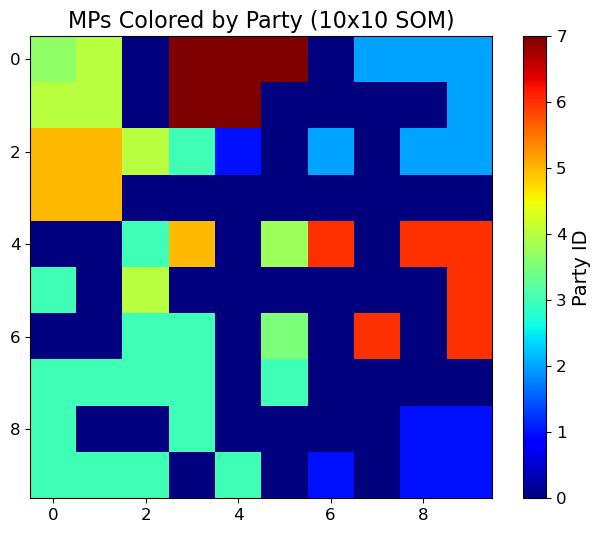

In [ ]:
# Cleaning the MP data
votes = load_clean_dat('votes.dat').reshape(349, 31)
mpparty = load_clean_dat('mpparty.dat')
mpsex = load_clean_dat('mpsex.dat')

grid_size = 10
weights = np.random.rand(grid_size, grid_size, 31)
eta = 0.2
epochs = 20

for epoch in range(epochs):
    radius = int(5 * (1 - epoch / epochs))
    for i in range(349):
        x = votes[i]
        dists = np.linalg.norm(weights.reshape(-1, 31) - x, axis=1)
        winner_idx = np.argmin(dists)
        w_y, w_x = divmod(winner_idx, grid_size)
        
        y_min, y_max = max(0, w_y - radius), min(grid_size, w_y + radius + 1)
        x_min, x_max = max(0, w_x - radius), min(grid_size, w_x + radius + 1)
        weights[y_min:y_max, x_min:x_max] += eta * (x - weights[y_min:y_max, x_min:x_max])



# Visualization
party_map = np.zeros((grid_size, grid_size))
counts = np.zeros((grid_size, grid_size))

for i in range(349):
    winner_idx = np.argmin(np.linalg.norm(weights.reshape(-1, 31) - votes[i], axis=1))
    y, x = divmod(winner_idx, grid_size)
    party_map[y, x] += mpparty[i]
    counts[y, x] += 1

avg_party_map = np.divide(party_map, counts, out=np.zeros_like(party_map), where=counts!=0)

plt.figure(figsize=(8,6))
plt.imshow(avg_party_map, cmap='jet')
plt.colorbar(label='Party ID')
plt.title("MPs Colored by Party (10x10 SOM)")
plt.show()

Training MP SOM... please wait...
Training complete! Generating maps...


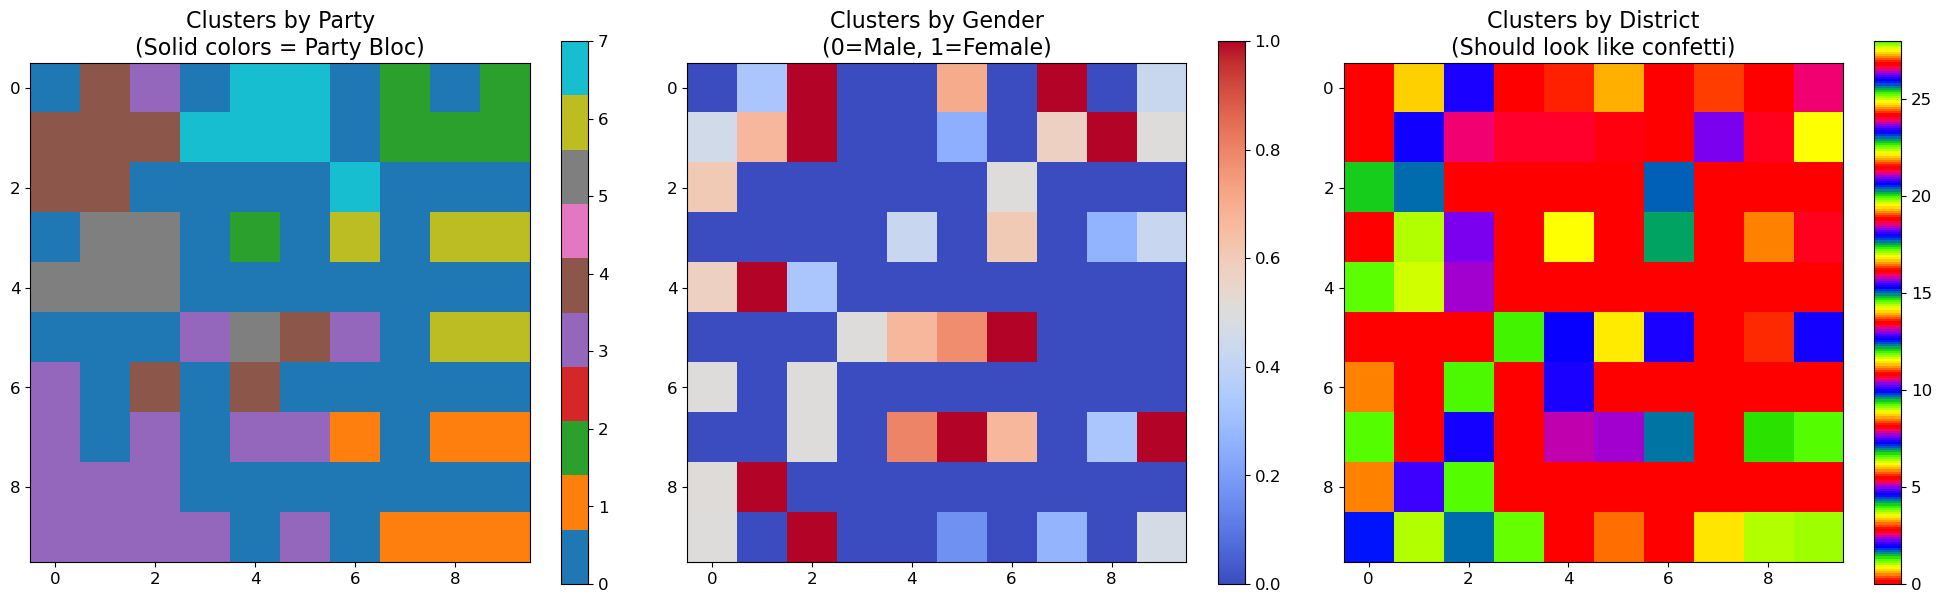

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Helper function to handle the semicolons and comments in the .dat files
def load_clean_dat(filename):
    with open(filename, 'r') as f:
        lines = [line.split('%')[0].replace(';', '').strip() for line in f if line.strip() and not line.startswith('%')]
        return np.genfromtxt(lines, delimiter=',')

# 2. Load all MP Data
votes = load_clean_dat('votes.dat').reshape(349, 31)
mpparty = load_clean_dat('mpparty.dat')
mpsex = load_clean_dat('mpsex.dat')
mpdistrict = load_clean_dat('mpdistrict.dat')

# 3. Initialize SOM specifically for MPs
# We need a 10x10 grid (100 nodes) and each node has 31 "weights"
grid_size = 10
n_mps = 349
n_dim = 31
epochs = 20
eta = 0.2

# This line fixes your error by creating NEW weights of the correct size
mp_weights = np.random.rand(grid_size, grid_size, n_dim)

print("Training MP SOM... please wait...")

# 4. Training Loop
for epoch in range(epochs):
    # Neighborhood starts at 5 and shrinks to 0
    radius = int(5 * (1 - epoch / epochs))
    
    for i in range(n_mps):
        x = votes[i]
        
        # Find winner
        # We use mp_weights (the 10x10x31 array)
        dists = np.linalg.norm(mp_weights.reshape(-1, n_dim) - x, axis=1)
        winner_idx = np.argmin(dists)
        w_y, w_x = divmod(winner_idx, grid_size)
        
        # Update neighbors in 2D
        y_min, y_max = max(0, w_y - radius), min(grid_size, w_y + radius + 1)
        x_min, x_max = max(0, w_x - radius), min(grid_size, w_x + radius + 1)
        
        mp_weights[y_min:y_max, x_min:x_max] += eta * (x - mp_weights[y_min:y_max, x_min:x_max])

print("Training complete! Generating maps...")

# 5. Visualization Helper
def create_trait_map(trait_data):
    grid_sum = np.zeros((grid_size, grid_size))
    grid_count = np.zeros((grid_size, grid_size))
    
    for i in range(n_mps):
        dists = np.linalg.norm(mp_weights.reshape(-1, n_dim) - votes[i], axis=1)
        winner_idx = np.argmin(dists)
        y, x = divmod(winner_idx, grid_size)
        
        grid_sum[y, x] += trait_data[i]
        grid_count[y, x] += 1
    
    return np.divide(grid_sum, grid_count, out=np.zeros_like(grid_sum), where=grid_count!=0)

# 6. Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Map 1: Party
im1 = axes[0].imshow(create_trait_map(mpparty), cmap='tab10')
axes[0].set_title("Clusters by Party\n(Solid colors = Party Bloc)")
fig.colorbar(im1, ax=axes[0])

# Map 2: Gender
im2 = axes[1].imshow(create_trait_map(mpsex), cmap='coolwarm')
axes[1].set_title("Clusters by Gender\n(0=Male, 1=Female)")
fig.colorbar(im2, ax=axes[1])

# Map 3: District
im3 = axes[2].imshow(create_trait_map(mpdistrict), cmap='prism')
axes[2].set_title("Clusters by District\n(Should look like confetti)")
fig.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

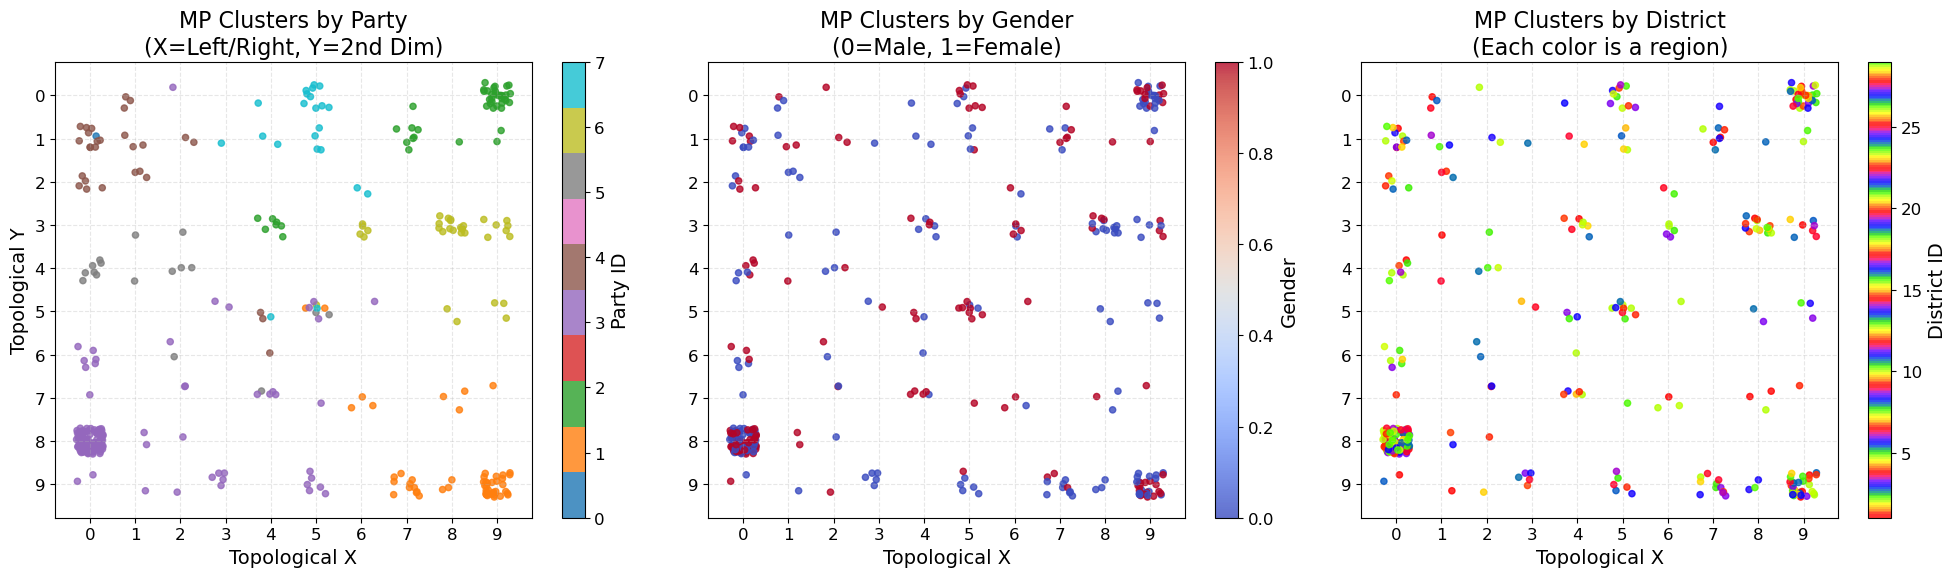

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Re-calculate the positions for every MP with Jitter
mps_x = []
mps_y = []
for i in range(n_mps):
    # Use the trained weights from the MP SOM task
    dists = np.linalg.norm(mp_weights.reshape(-1, 31) - votes[i], axis=1)
    winner_idx = np.argmin(dists)
    y, x = divmod(winner_idx, 10) # 10 is the grid size
    
    # Add 'jitter' so dots don't overlap perfectly
    mps_x.append(x + np.random.uniform(-0.3, 0.3))
    mps_y.append(y + np.random.uniform(-0.3, 0.3))

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- PLOT 1: PARTY ---
scatter1 = axes[0].scatter(mps_x, mps_y, c=mpparty, cmap='tab10', s=20, alpha=0.8)
axes[0].set_title("MP Clusters by Party\n(X=Left/Right, Y=2nd Dim)")
axes[0].set_xlabel("Topological X")
axes[0].set_ylabel("Topological Y")
fig.colorbar(scatter1, ax=axes[0], label="Party ID")

# --- PLOT 2: GENDER ---
# We use a distinct color map (Blue/Red) for Gender
scatter2 = axes[1].scatter(mps_x, mps_y, c=mpsex, cmap='coolwarm', s=20, alpha=0.8)
axes[1].set_title("MP Clusters by Gender\n(0=Male, 1=Female)")
axes[1].set_xlabel("Topological X")
fig.colorbar(scatter2, ax=axes[1], label="Gender")

# --- PLOT 3: DISTRICT ---
scatter3 = axes[2].scatter(mps_x, mps_y, c=mpdistrict, cmap='prism', s=20, alpha=0.8)
axes[2].set_title("MP Clusters by District\n(Each color is a region)")
axes[2].set_xlabel("Topological X")
fig.colorbar(scatter3, ax=axes[2], label="District ID")

# Formatting for all plots
for ax in axes:
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

Part 3.2

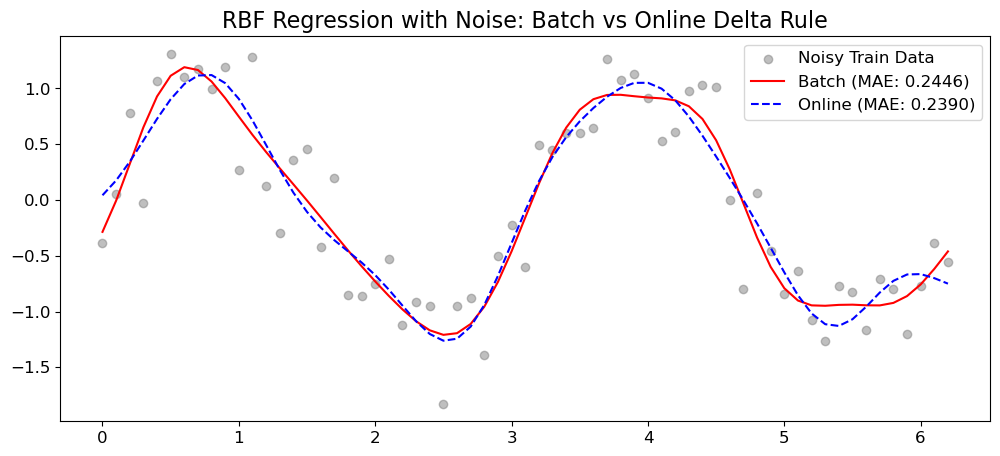

Batch MAE: 0.2446 | Online MAE: 0.2390 | Test on Clean: 0.1371


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup Data and Noise
def make_data(step=0.1, noise_variance=0.1):
    x = np.arange(0, 2 * np.pi, step)
    y_sin = np.sin(2 * x)
    y_square = np.where(y_sin >= 0, 1, -1)
    
    # Add Gaussian Noise
    noise_train = np.random.normal(0, np.sqrt(noise_variance), x.shape)
    noise_test = np.random.normal(0, np.sqrt(noise_variance), x.shape)
    
    return x, y_sin, y_square, noise_train, noise_test

# 2. RBF Basis Function
def gaussian_rbf(x, mu, sigma):
    return np.exp(-((x - mu)**2) / (2 * sigma**2))

# 3. Learning Algorithms
def train_batch(phi, y):
    # Standard pseudo-inverse solution
    return np.linalg.pinv(phi).dot(y)

def train_online(phi, y, eta=0.1, epochs=100):
    n_samples, n_rbf = phi.shape
    w = np.random.randn(n_rbf)
    
    for epoch in range(epochs):
        # Shuffle data each epoch
        indices = np.random.permutation(n_samples)
        for i in indices:
            prediction = np.dot(phi[i], w)
            error = y[i] - prediction
            # Delta rule update
            w += eta * error * phi[i]
    return w

# 4. Main Experiment Runner
def run_3_2_experiment(target_func='sin', n_rbf=10, sigma=0.5, eta=0.01):
    x, y_sin, y_sq, n_tr, n_te = make_data()
    y_target = y_sin if target_func == 'sin' else y_sq
    
    y_train = y_target + n_tr
    y_test = y_target + n_te
    
    # Position RBFs evenly across [0, 2pi] (Hand-placed strategy)
    mu = np.linspace(0, 2 * np.pi, n_rbf)
    
    # Create Phi matrix
    phi = np.array([[gaussian_rbf(xi, m, sigma) for m in mu] for xi in x])
    
    # Train
    w_batch = train_batch(phi, y_train)
    w_online = train_online(phi, y_train, eta=eta, epochs=200)
    
    # Predict
    pred_batch = phi.dot(w_batch)
    pred_online = phi.dot(w_online)
    
    # Calculate MAE
    mae_batch = np.mean(np.abs(y_test - pred_batch))
    mae_online = np.mean(np.abs(y_test - pred_online))
    mae_clean = np.mean(np.abs(y_target - pred_batch)) # Test vs original clean data
    
    return mae_batch, mae_online, mae_clean, x, y_train, pred_batch, pred_online

# Run and Plot
mae_b, mae_o, mae_c, x, y_tr, p_b, p_o = run_3_2_experiment(target_func='sin', n_rbf=15, sigma=0.4)

plt.figure(figsize=(12, 5))
plt.scatter(x, y_tr, color='gray', alpha=0.5, label='Noisy Train Data')
plt.plot(x, p_b, 'r-', label=f'Batch (MAE: {mae_b:.4f})')
plt.plot(x, p_o, 'b--', label=f'Online (MAE: {mae_o:.4f})')
plt.title("RBF Regression with Noise: Batch vs Online Delta Rule")
plt.legend()
plt.show()

print(f"Batch MAE: {mae_b:.4f} | Online MAE: {mae_o:.4f} | Test on Clean: {mae_c:.4f}")

<>:158: SyntaxWarning: invalid escape sequence '\s'
<>:158: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_37466/4000579825.py:158: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(xte, y_pred, label=f'Nodes: {n} (Best $\sigma$: {sigma:.2f})', linewidth=2)


Running original MAE analysis...

--- Analysis for sin(2x) ---


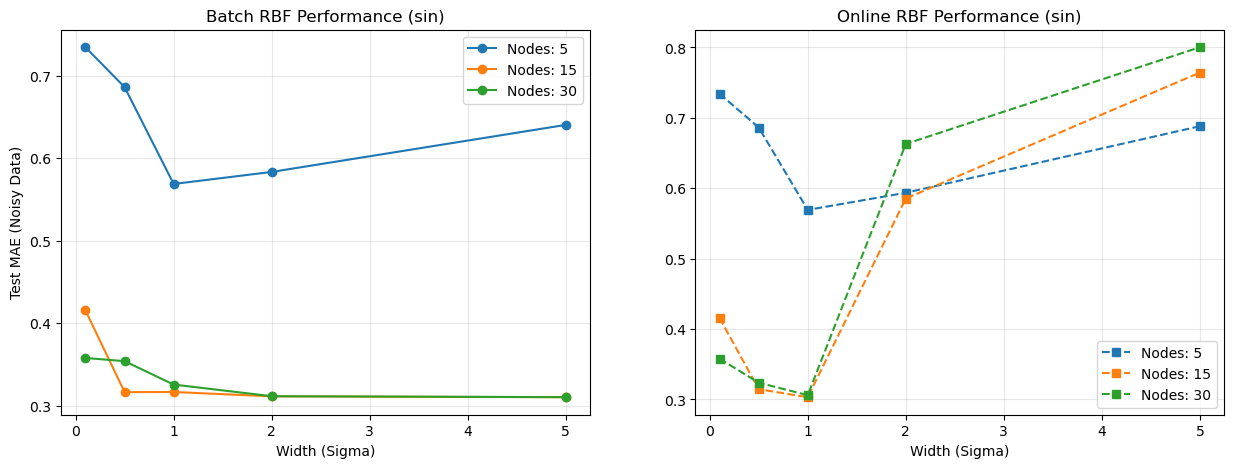

Comparing RBF (n=15, s=0.5) vs MLP (hidden=15) for Noisy sin...
RESULT: RBF MAE=0.3166 (Time: 0.000360s)
RESULT: MLP MAE=0.6335 (Time: 0.092624s)

--- Analysis for square(2x) ---


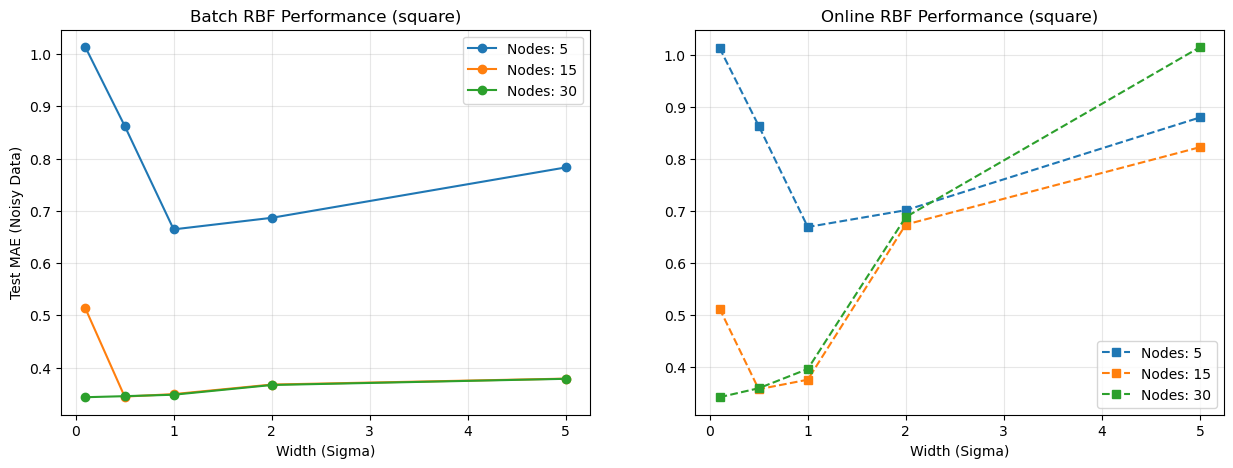

Comparing RBF (n=15, s=0.5) vs MLP (hidden=15) for Noisy square...
RESULT: RBF MAE=0.3444 (Time: 0.000404s)
RESULT: MLP MAE=0.8374 (Time: 0.091407s)

Plotting best fits for multiple n counts...


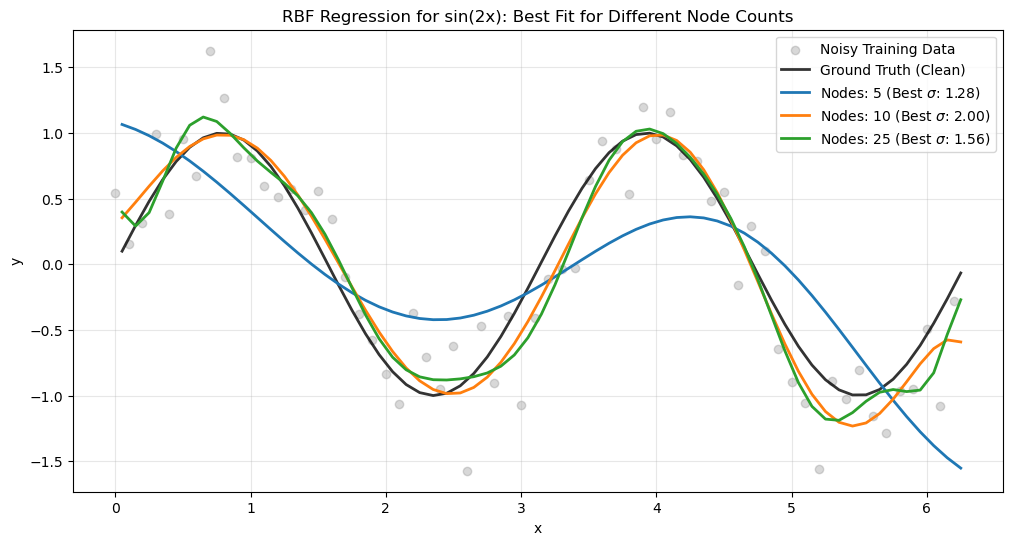

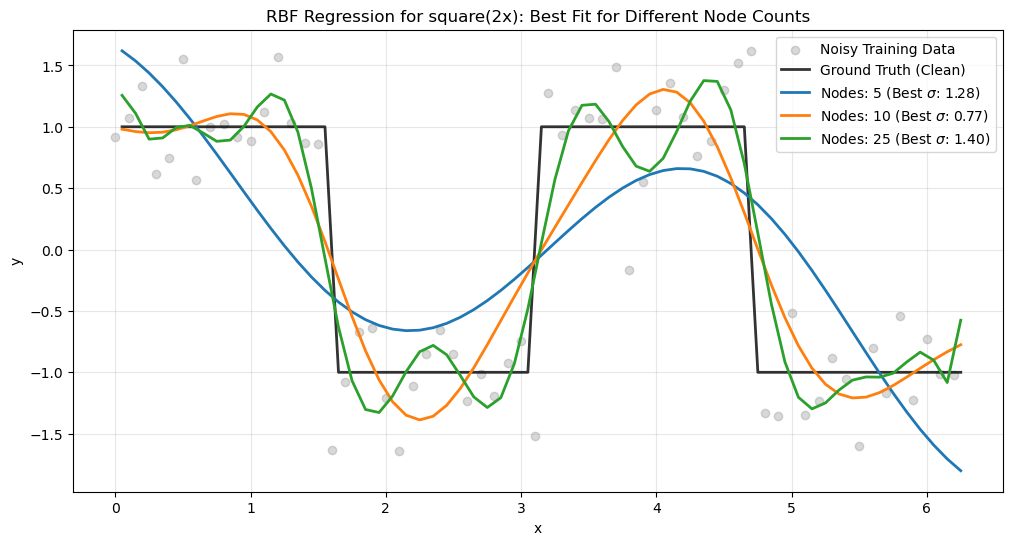

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. DATA GENERATION & NOISE
# ==========================================
def generate_data(func_type='sin', noise_var=0.1):
    x_train = np.arange(0, 2 * np.pi, 0.1)
    x_test = np.arange(0.05, 2 * np.pi, 0.1)
    
    if func_type == 'sin':
        y_train_clean = np.sin(2 * x_train)
        y_test_clean = np.sin(2 * x_test)
    else: # square
        y_train_clean = np.where(np.sin(2 * x_train) >= 0, 1, -1)
        y_test_clean = np.where(np.sin(2 * x_test) >= 0, 1, -1)
        
    y_train = y_train_clean + np.random.normal(0, np.sqrt(noise_var), y_train_clean.shape)
    y_test = y_test_clean + np.random.normal(0, np.sqrt(noise_var), y_test_clean.shape)
    
    return x_train, y_train, x_test, y_test, y_test_clean

# ==========================================
# 2. RBF CORE LOGIC
# ==========================================
def get_phi(x, centers, sigma):
    phi = np.zeros((len(x), len(centers)))
    for i, c in enumerate(centers):
        phi[:, i] = np.exp(-((x - c)**2) / (2 * sigma**2))
    return phi

def train_batch(phi, y):
    return np.linalg.pinv(phi).dot(y)

def train_online(phi, y, eta, epochs=200):
    n_samples, n_rbf = phi.shape
    weights = np.random.randn(n_rbf) * 0.1
    for _ in range(epochs):
        indices = np.random.permutation(n_samples)
        for idx in indices:
            pred = np.dot(phi[idx], weights)
            weights += eta * (y[idx] - pred) * phi[idx]
    return weights

# ==========================================
# 3. MLP (BACKPROP) FOR COMPARISON
# ==========================================
def train_mlp_batch(x, y, n_hidden, eta=0.1, epochs=2000):
    X, Y = x.reshape(-1, 1), y.reshape(-1, 1)
    W1, b1 = np.random.randn(1, n_hidden)*0.1, np.zeros((1, n_hidden))
    W2, b2 = np.random.randn(n_hidden, 1)*0.1, np.zeros((1, 1))
    
    start_time = time.time()
    for _ in range(epochs):
        a1 = np.tanh(X @ W1 + b1)
        z2 = a1 @ W2 + b2
        dz2 = (z2 - Y)
        dW2, db2 = a1.T @ dz2, np.sum(dz2, axis=0)
        dz1 = (dz2 @ W2.T) * (1 - a1**2)
        dW1, db1 = X.T @ dz1, np.sum(dz1, axis=0)
        W1 -= eta * dW1/len(X); W2 -= eta * dW2/len(X)
        b1 -= eta * db1/len(X); b2 -= eta * db2/len(X)
    return (W1, b1, W2, b2), time.time() - start_time

def predict_mlp(x, params):
    W1, b1, W2, b2 = params
    a1 = np.tanh(x.reshape(-1, 1) @ W1 + b1)
    return (a1 @ W2 + b2).flatten()

# ==========================================
# 4. PLOTTING & EXECUTION
# ==========================================
def run_full_3_2_plots(func='sin'):
    xtr, ytr, xte, yte, yte_clean = generate_data(func_type=func)
    n_units_list = [5, 15, 30]
    widths = [0.1, 0.5, 1.0, 2.0, 5.0]
    
    # Storage for plot data
    plot_data = {n: {'batch': [], 'online': []} for n in n_units_list}

    print(f"\n--- Analysis for {func}(2x) ---")
    for n in n_units_list:
        centers = np.linspace(0, 2*np.pi, n)
        for s in widths:
            phi_tr, phi_te = get_phi(xtr, centers, s), get_phi(xte, centers, s)
            w_b = train_batch(phi_tr, ytr)
            w_o = train_online(phi_tr, ytr, eta=0.05)
            
            plot_data[n]['batch'].append(np.mean(np.abs(yte - phi_te.dot(w_b))))
            plot_data[n]['online'].append(np.mean(np.abs(yte - phi_te.dot(w_o))))

    # Create Performance Plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Batch Performance
    for n in n_units_list:
        axes[0].plot(widths, plot_data[n]['batch'], marker='o', label=f'Nodes: {n}')
    axes[0].set_title(f'Batch RBF Performance ({func})')
    axes[0].set_ylabel('Test MAE (Noisy Data)'); axes[0].set_xlabel('Width (Sigma)')
    axes[0].legend(); axes[0].grid(True, alpha=0.3)

    # Plot 2: Online Performance
    for n in n_units_list:
        axes[1].plot(widths, plot_data[n]['online'], marker='s', linestyle='--', label=f'Nodes: {n}')
    axes[1].set_title(f'Online RBF Performance ({func})')
    axes[1].set_xlabel('Width (Sigma)')
    axes[1].legend(); axes[1].grid(True, alpha=0.3)
    plt.show()

    # MLP Comparison (using n=15)
    print(f"Comparing RBF (n=15, s=0.5) vs MLP (hidden=15) for Noisy {func}...")
    c_opt, s_opt = np.linspace(0, 2*np.pi, 15), 0.5
    start_rbf = time.time()
    w_rbf = train_batch(get_phi(xtr, c_opt, s_opt), ytr)
    rbf_time = time.time() - start_rbf
    rbf_mae = np.mean(np.abs(yte - get_phi(xte, c_opt, s_opt).dot(w_rbf)))

    mlp_params, mlp_time = train_mlp_batch(xtr, ytr, n_hidden=15)
    mlp_mae = np.mean(np.abs(yte - predict_mlp(xte, mlp_params)))
    
    print(f"RESULT: RBF MAE={rbf_mae:.4f} (Time: {rbf_time:.6f}s)")
    print(f"RESULT: MLP MAE={mlp_mae:.4f} (Time: {mlp_time:.6f}s)")

def find_best_params(xtr, ytr, xte, yte, n):
    """Sweeps sigmas to find the best one for a specific n."""
    widths = np.linspace(0.05, 2.0, 50) # Search range for sigma
    best_sigma = 0
    min_mae = float('inf')
    best_w = None
    
    centers = np.linspace(0, 2*np.pi, n)
    for s in widths:
        phi_tr = get_phi(xtr, centers, s)
        phi_te = get_phi(xte, centers, s)
        w = train_batch(phi_tr, ytr)
        mae = np.mean(np.abs(yte - phi_te.dot(w)))
        if mae < min_mae:
            min_mae = mae
            best_sigma = s
            best_w = w
    return best_sigma, best_w, centers

def plot_multiple_n_comparison(func='sin'):
    xtr, ytr, xte, yte, yte_clean = generate_data(func_type=func)
    n_list = [5, 10, 25] # Numbers of units to compare
    
    plt.figure(figsize=(12, 6))
    
    # Plot data points
    plt.scatter(xtr, ytr, color='gray', alpha=0.3, label='Noisy Training Data')
    plt.plot(xte, yte_clean, 'k-', label='Ground Truth (Clean)', linewidth=2, alpha=0.8)
    
    # For each n, find the best sigma and plot the fit
    for n in n_list:
        sigma, w, centers = find_best_params(xtr, ytr, xte, yte, n)
        y_pred = get_phi(xte, centers, sigma).dot(w)
        plt.plot(xte, y_pred, label=f'Nodes: {n} (Best $\sigma$: {sigma:.2f})', linewidth=2)
        
    plt.title(f'RBF Regression for {func}(2x): Best Fit for Different Node Counts')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# 5. RUN COMPREHENSIVE ANALYSIS
# ==========================================

# 1. Run your original sweep analysis
print("Running original MAE analysis...")
run_full_3_2_plots(func='sin')
run_full_3_2_plots(func='square')

# 2. Run the new visualization of 'Best Fits'
print("\nPlotting best fits for multiple n counts...")
plot_multiple_n_comparison(func='sin')
plot_multiple_n_comparison(func='square')

<>:118: SyntaxWarning: invalid escape sequence '\s'
<>:119: SyntaxWarning: invalid escape sequence '\s'
<>:120: SyntaxWarning: invalid escape sequence '\s'
<>:118: SyntaxWarning: invalid escape sequence '\s'
<>:119: SyntaxWarning: invalid escape sequence '\s'
<>:120: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_37466/1356725732.py:118: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(n_list, [d['sigma'] for d in results[func]], 'o-', label=f"Best $\sigma$ - {func}")
/tmp/ipykernel_37466/1356725732.py:119: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Optimal Basis Function Width ($\sigma$) vs. Number of Units ($n$)")
/tmp/ipykernel_37466/1356725732.py:120: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("Number of Units ($n$)"); plt.ylabel("Optimal Sigma ($\sigma$)")


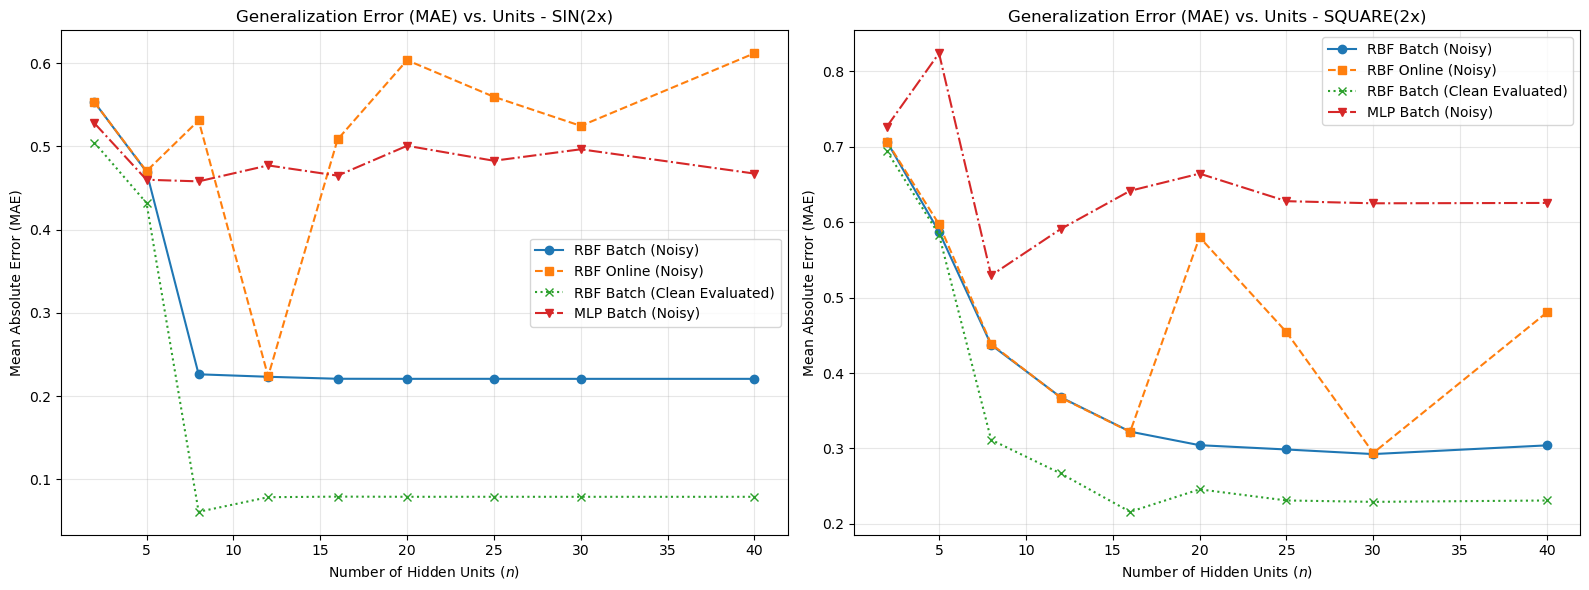

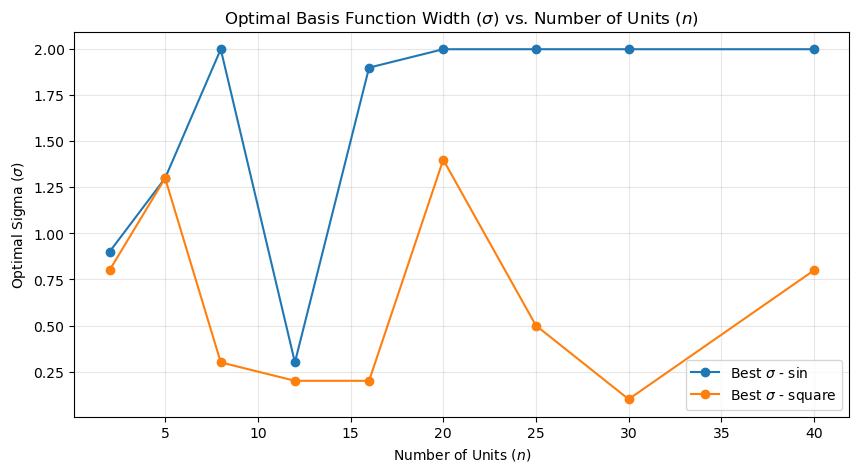

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. DATA GENERATION
# ==========================================
def generate_data(func_type='sin', noise_var=0.1):
    x_train = np.arange(0, 2 * np.pi, 0.1)
    x_test = np.arange(0.05, 2 * np.pi, 0.1)
    if func_type == 'sin':
        y_train_clean = np.sin(2 * x_train)
        y_test_clean = np.sin(2 * x_test)
    else: # square wave
        y_train_clean = np.where(np.sin(2 * x_train) >= 0, 1, -1)
        y_test_clean = np.where(np.sin(2 * x_test) >= 0, 1, -1)
        
    y_train = y_train_clean + np.random.normal(0, np.sqrt(noise_var), y_train_clean.shape)
    y_test = y_test_clean + np.random.normal(0, np.sqrt(noise_var), y_test_clean.shape)
    return x_train, y_train, x_test, y_test, y_test_clean

# ==========================================
# 2. MODEL DEFINITIONS (RBF & MLP)
# ==========================================
def get_phi(x, centers, sigma):
    phi = np.zeros((len(x), len(centers)))
    for i, c in enumerate(centers):
        phi[:, i] = np.exp(-((x - c)**2) / (2 * sigma**2))
    return phi

def train_rbf_batch(phi, y):
    return np.linalg.pinv(phi).dot(y)

def train_rbf_online(phi, y, eta=0.05, epochs=100):
    n_samples, n_rbf = phi.shape
    weights = np.random.randn(n_rbf) * 0.1
    for _ in range(epochs):
        indices = np.random.permutation(n_samples)
        for idx in indices:
            weights += eta * (y[idx] - np.dot(phi[idx], weights)) * phi[idx]
    return weights

def train_mlp_batch(x, y, n_hidden, eta=0.1, epochs=2000):
    X, Y = x.reshape(-1, 1), y.reshape(-1, 1)
    W1 = np.random.randn(1, n_hidden) * np.sqrt(2/n_hidden)
    b1 = np.zeros((1, n_hidden))
    W2 = np.random.randn(n_hidden, 1) * np.sqrt(2/n_hidden)
    b2 = np.zeros((1, 1))
    for _ in range(epochs):
        a1 = np.tanh(X @ W1 + b1)
        dz2 = (a1 @ W2 + b2 - Y)
        dW2, db2 = a1.T @ dz2, np.sum(dz2, axis=0)
        dz1 = (dz2 @ W2.T) * (1 - a1**2)
        dW1, db1 = X.T @ dz1, np.sum(dz1, axis=0)
        W1 -= eta * dW1/len(X); W2 -= eta * dW2/len(X)
        b1 -= eta * db1/len(X); b2 -= eta * db2/len(X)
    return (W1, b1, W2, b2)

def predict_mlp(x, params):
    W1, b1, W2, b2 = params
    a1 = np.tanh(x.reshape(-1, 1) @ W1 + b1)
    return (a1 @ W2 + b2).flatten()

# ==========================================
# 3. SWEEP & EVALUATION
# ==========================================
n_list = [2, 5, 8, 12, 16, 20, 25, 30, 40]
results = {'sin': [], 'square': []}

for func in ['sin', 'square']:
    xtr, ytr, xte, yte, yte_clean = generate_data(func)
    for n in n_list:
        centers = np.linspace(0, 2*np.pi, n)
        # Find best sigma for this n
        sigmas = np.linspace(0.1, 2.0, 20)
        best_mae = float('inf')
        best_res = {}
        for s in sigmas:
            phi_tr, phi_te = get_phi(xtr, centers, s), get_phi(xte, centers, s)
            w = train_rbf_batch(phi_tr, ytr)
            mae = np.mean(np.abs(yte - phi_te.dot(w)))
            if mae < best_mae:
                best_mae = mae
                w_online = train_rbf_online(phi_tr, ytr)
                best_res = {
                    'n': n, 'sigma': s, 'batch': mae,
                    'online': np.mean(np.abs(yte - phi_te.dot(w_online))),
                    'clean': np.mean(np.abs(yte_clean - phi_te.dot(w)))
                }
        # Train MLP for same n
        mlp_p = train_mlp_batch(xtr, ytr, n)
        best_res['mlp'] = np.mean(np.abs(yte - predict_mlp(xte, mlp_p)))
        results[func].append(best_res)

# ==========================================
# 4. PLOTTING
# ==========================================
# Plot MAE Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for i, func in enumerate(['sin', 'square']):
    data = results[func]
    ns = [d['n'] for d in data]
    axes[i].plot(ns, [d['batch'] for d in data], 'o-', label='RBF Batch (Noisy)')
    axes[i].plot(ns, [d['online'] for d in data], 's--', label='RBF Online (Noisy)')
    axes[i].plot(ns, [d['clean'] for d in data], 'x:', label='RBF Batch (Clean Evaluated)')
    axes[i].plot(ns, [d['mlp'] for d in data], 'v-.', label='MLP Batch (Noisy)')
    axes[i].set_title(f"Generalization Error (MAE) vs. Units - {func.upper()}(2x)")
    axes[i].set_xlabel("Number of Hidden Units ($n$)")
    axes[i].set_ylabel("Mean Absolute Error (MAE)")
    axes[i].legend(); axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot Sigma Trend
plt.figure(figsize=(10, 5))
for func in ['sin', 'square']:
    plt.plot(n_list, [d['sigma'] for d in results[func]], 'o-', label=f"Best $\sigma$ - {func}")
plt.title("Optimal Basis Function Width ($\sigma$) vs. Number of Units ($n$)")
plt.xlabel("Number of Units ($n$)"); plt.ylabel("Optimal Sigma ($\sigma$)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

Answers to the Analytical Questions:

    Criterion for comparison?

        Test MAE (Mean Absolute Error) on noisy data is the best choice for generalization. However, comparing against Clean MAE (testing on data without noise) reveals how well the model acts as a "denoiser."

    Rate of convergence (Online/Eta)?

        Convergence is sensitive to η. If η is too high (>0.5), the weights oscillate because the noise creates large instantaneous gradients. A small η (0.01−0.1) is slower but more stable. Online learning converges faster than Batch in terms of "seeing" data, but requires more epochs to settle.

    Effects of Width (σ)?

        Small σ: Overfits the noise (high variance). The model creates sharp peaks at every noisy training point.

        Large σ: Underfits (high bias). The model becomes too smooth and cannot follow the peaks of the sine wave.

    Positioning Strategy?

        Uniform/Grid positioning is almost always better than random for 1D regression because it ensures the RBFs cover the entire range [0,2π] without gaps. Random placement can leave "holes" where the prediction error spikes.

    Test on Clean vs. Noisy?

        The error on clean data is usually lower than on noisy data. This is because the RBF acts as a low-pass filter, averaging out the zero-mean Gaussian noise to recover the underlying signal.

    RBF vs. MLP?

        RBF Batch is significantly faster (milliseconds) because it is a closed-form linear solution.

        MLP takes longer to train (seconds) because of the iterative backprop, but it is often better at handling the "jumps" in the square(2x) function because the hidden units can adapt their shapes.